# Descripcion del Proyecto

Rusty Bargain es un servicio de venta de coches de segunda mano que está desarrollando una app para atraer a nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial, especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.

A Rusty Bargain le interesa:

- la calidad de la predicción
- la velocidad de la predicción
- el tiempo requerido para el entrenamiento

## Instrucciones del Proyecto

1. Descarga y examina los datos.
2. Entrena diferentes modelos con varios hiperparámetros (debes hacer al menos dos modelos diferentes, pero más es mejor. Recuerda, varias implementaciones de potenciación del gradiente no cuentan como modelos diferentes). El punto principal de este paso es comparar métodos de potenciación del gradiente con bosque aleatorio, árbol de decisión y regresión lineal.
3. Analiza la velocidad y la calidad de los modelos.

Observaciones:

- Utiliza la métrica RECM para evaluar los modelos.
- La regresión lineal no es muy buena para el ajuste de hiperparámetros, pero es perfecta para hacer una prueba de cordura de otros métodos. Si la potenciación del gradiente funciona peor que la regresión lineal, definitivamente algo salió mal.
- Aprende por tu propia cuenta sobre la librería LightGBM y sus herramientas para crear modelos de potenciación del gradiente (gradient boosting).
- Idealmente, tu proyecto debe tener regresión lineal para una prueba de cordura, un algoritmo basado en árbol con ajuste de hiperparámetros (preferiblemente, bosque aleatorio), LightGBM con ajuste de hiperparámetros (prueba un par de conjuntos), y CatBoost y XGBoost con ajuste de hiperparámetros (opcional).
- Toma nota de la codificación de características categóricas para algoritmos simples. LightGBM y CatBoost tienen su implementación, pero XGBoost requiere OHE.
- Puedes usar un comando especial para encontrar el tiempo de ejecución del código de celda en Jupyter Notebook. Encuentra ese comando.
- Dado que el entrenamiento de un modelo de potenciación del gradiente puede llevar mucho tiempo, cambia solo algunos parámetros del modelo.
- Si Jupyter Notebook deja de funcionar, elimina las variables excesivas por medio del operador del: 
del features_train


## Descripción de los Datos

El dataset está almacenado en el archivo /datasets/car_data.csv. descargar dataset. https://practicum-content.s3.us-west-1.amazonaws.com/datasets/car_data.csv


**Características**

- *DateCrawled* — fecha en la que se descargó el perfil de la base de datos
- *VehicleType* — tipo de carrocería del vehículo
- *RegistrationYear* — año de matriculación del vehículo
- *Gearbox* — tipo de caja de cambios
- *Power* — potencia (CV)
- *Model* — modelo del vehículo
- *Mileage* — kilometraje (medido en km de acuerdo con las especificidades regionales del conjunto de datos)
- *RegistrationMonth* — mes de matriculación del vehículo
- *FuelType* — tipo de combustible
- *Brand* — marca del vehículo
- *NotRepaired* — vehículo con o sin reparación
- *DateCreated* — fecha de creación del perfil
- *NumberOfPictures* — número de fotos del vehículo
- *PostalCode* — código postal del propietario del perfil (usuario)
- *LastSeen* — fecha de la última vez que el usuario estuvo activo

**Objetivo**

- *Price* — precio (en euros)


## Evaluación del Proyecto

Hemos definido los criterios de evaluación para el proyecto. Léelos con atención antes de pasar al ejercicio.

Esto es en lo que se fijarán los revisores al examinar tu proyecto:

- ¿Seguiste todos los pasos de las instrucciones?
- ¿Cómo preparaste los datos?
- ¿Qué modelos e hiperparámetros consideraste?
- ¿Conseguiste evitar la duplicación del código?
- ¿Cuáles son tus hallazgos?
- ¿Mantuviste la estructura del proyecto?
- ¿Mantuviste el código ordenado?

Ya tienes tus hojas informativas y los resúmenes de los capítulos, por lo que todo está listo para continuar con el proyecto.

El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## Preparación de datos

### Importar Librerias y DF

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.compose import ColumnTransformer

In [71]:
df = pd.read_csv('datasets/car_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [72]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [73]:
df.isna().mean().sort_values(ascending=False)

NotRepaired          0.200791
VehicleType          0.105794
FuelType             0.092827
Gearbox              0.055967
Model                0.055606
DateCrawled          0.000000
Price                0.000000
RegistrationYear     0.000000
Power                0.000000
Mileage              0.000000
RegistrationMonth    0.000000
Brand                0.000000
DateCreated          0.000000
NumberOfPictures     0.000000
PostalCode           0.000000
LastSeen             0.000000
dtype: float64

In [74]:
df.duplicated().sum()

262

Hay columnas que no son relevantes para mi modelo, entre estas se encuentra la fecha en la que se descargo al información, el codigo postal, numero de fotografias y el resto de las fechas. Tambien retiraria el mes de matriculación ya que tomaremos el año de matriculación como el año del modelo del vehiculo. El mes podria agregarnos ruido inecesario.

In [75]:
#Dropeamos las columnas que no nos serviran para entrenar nuestro modelo
columns_to_drop = ['DateCrawled','DateCreated','NumberOfPictures','PostalCode','LastSeen','RegistrationMonth']
df = df.drop(columns = columns_to_drop)

In [76]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

Encontramos que petrol y gasoline significan lo mismo, petrol es el nombre usado en UK, gasoline es en America. Estandarizamos el nombre a gasoline.

In [77]:
# Cambiamos petrol a gasoline
df['FuelType'] = df['FuelType'].replace('petrol', 'gasoline')
# Imputamos valores desconocido a categoria unknown
df['FuelType'] = df['FuelType'].fillna('unknown')

In [78]:
df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,gasoline,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [79]:
df['RegistrationYear'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [80]:
((df['RegistrationYear'] >= 1990) & (df['RegistrationYear'] <= 2019)).sum()

344595

Tenemos 344595 valores entre los años 1990 y 2019, el total son 354369. Estamos hablando que 97.5% de los datos se encuentran en este rango de años, eliminaremos todos los años que aun no suceden (Despues del 2060, y aquellos antes de 1990).

In [81]:
df = df[(df['RegistrationYear'] >= 1990) & (df['RegistrationYear'] <= 2019)]

In [82]:
# Valores de la columna NotRepaired los pasamos a binario, y los NaN los pasamos como -1
df.loc[df["NotRepaired"] == "yes", "NotRepaired"] = 1
df.loc[df["NotRepaired"] == "no", "NotRepaired"] = 0
df.loc[:, 'NotRepaired'] = df['NotRepaired'].fillna(-1)

df.head()

/var/folders/75/n09kg0s137s895fc3yg04jg00000gn/T/ipykernel_66228/697654838.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.loc[:, 'NotRepaired'] = df['NotRepaired'].fillna(-1)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,gasoline,volkswagen,-1
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,1
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,-1
3,1500,small,2001,manual,75,golf,150000,gasoline,volkswagen,0
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,0


<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a><br> <b>Éxito</b> - ¡Buen comienzo! Has hecho una carga de datos clara, identificaste valores nulos y tomaste decisiones justificadas para limpiar el dataset. También eliminaste columnas irrelevantes y corregiste inconsistencias en los datos de forma acertada. Vas construyendo una base sólida para el modelado. </div>


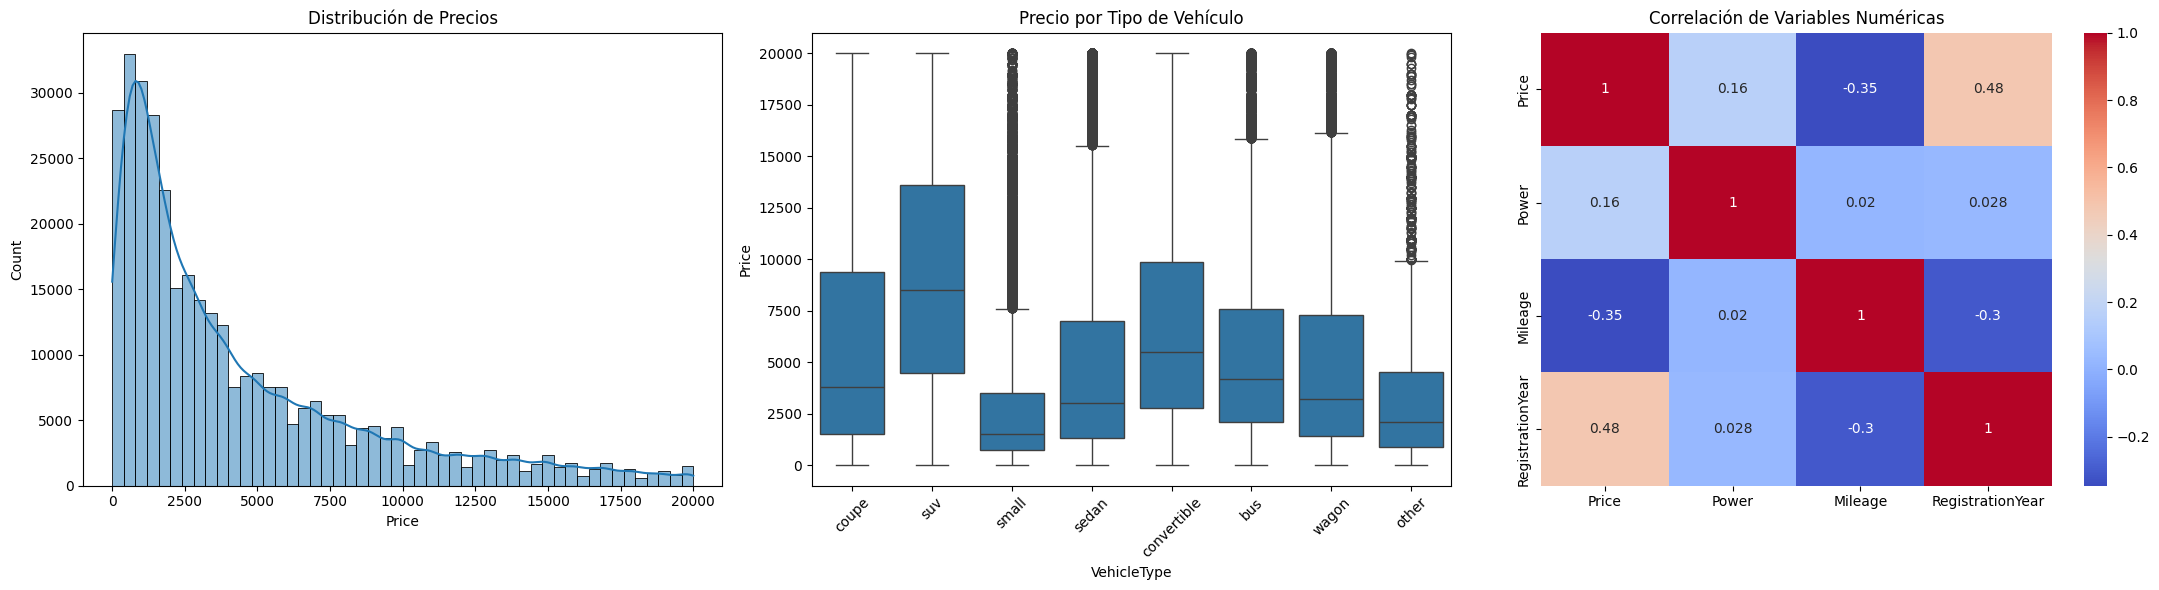

In [83]:
# Visualizamos mas datos

# Hago mis subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22, 6))
plt.subplots_adjust(wspace=0.4)  # Espacio entre los subgráficos

# --- 1. Histograma de precios ---
sns.histplot(df['Price'], bins=50, kde=True, ax=axes[0])
axes[0].set_title("Distribución de Precios")

# --- 2. Boxplot por tipo de vehículo ---
sns.boxplot(x='VehicleType', y='Price', data=df, ax=axes[1])
axes[1].set_title("Precio por Tipo de Vehículo")
axes[1].tick_params(axis='x', rotation=45)

# --- 3. Heatmap de correlaciones ---
numeric_cols = ['Price', 'Power', 'Mileage', 'RegistrationYear']
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', ax=axes[2])
axes[2].set_title("Correlación de Variables Numéricas")

plt.tight_layout()
plt.show()

In [84]:
df.describe()

,Price,RegistrationYear,Power,Mileage
count,344595.000000,344595.000000,344595.000000,344595.000000
mean,4407.169886,2003.744457,110.805772,128881.919355
std,4503.292807,6.205658,187.221179,37183.479089
min,0.000000,1990.000000,0.000000,5000.000000
25%,1050.000000,1999.000000,69.000000,125000.000000
50%,2700.000000,2003.000000,105.000000,150000.000000
75%,6390.000000,2008.000000,143.000000,150000.000000
max,20000.000000,2019.000000,20000.000000,150000.000000


Tenemos valores de 0 en precio, y valores de 0 en potencia. Chequemos el por que de esos valores.

In [85]:
# Ver precios en 0
print("Precios en cero:", (df["Price"] == 0).sum())
# Ver potencias en 0
print("Potencia en cero:", (df["Power"] == 0).sum())

Precios en cero: 10008
Potencia en cero: 37768


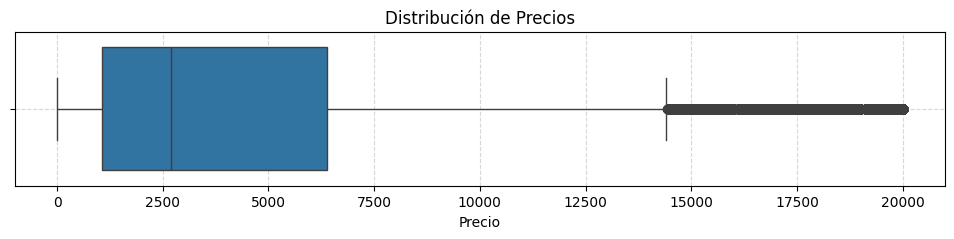

In [86]:
# Boxplot para visualizar Precio
plt.figure(figsize=(12, 2))
sns.boxplot(x=df['Price'])
plt.title("Distribución de Precios")
plt.xlabel("Precio")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Debido a que tenemos 10k valores en 0 y 300k valores totales, y que adicionalmente nuestra columna de Price es la variable objetivo. Hemos decidido eliminar los valores en 0  en lugar de imputarlo, esto a que no queremos que el modelo aprenda sobre datos inflados, o falsos datos.

In [87]:
def limpiar_outliers(df, columna='Price', minimo_valido=500):
    """
    Elimina precios atípicos e inválidos usando un mínimo definido y el método IQR.
    
    Parámetros:
    - df: DataFrame original
    - columna: Nombre de la columna a limpiar (por defecto 'Price')
    - minimo_valido: Precio mínimo considerado válido (por defecto 100)

    Retorna:
    - DataFrame limpio
    - Diccionario con los umbrales usados
    """

    # Eliminar valores menores al mínimo permitido
    df_filtrado = df[df[columna] >= minimo_valido]

    # Calcular IQR para valores superiores
    Q1 = df_filtrado[columna].quantile(0.25)
    Q3 = df_filtrado[columna].quantile(0.75)
    IQR = Q3 - Q1
    techo = Q3 + 1.5 * IQR

    # Filtrar valores superiores al techo
    df_limpio = df_filtrado[df_filtrado[columna] <= techo]

    # Opcional: mostrar resumen
    print(f"Valores eliminados por debajo de {minimo_valido}: {len(df) - len(df_filtrado)}")
    print(f"Valores eliminados por encima de {techo:.0f} (outliers superiores): {len(df_filtrado) - len(df_limpio)}")
    print(f"Total restante: {len(df_limpio)} filas")

    return df_limpio, {'minimo': minimo_valido, 'techo': techo}

In [88]:
# Estableciendo un valor minimo de 500 euros para threshold de precio
df, umbrales_precio = limpiar_outliers(df, 'Price', 500)

Valores eliminados por debajo de 500: 34602
Valores eliminados por encima de 15124 (outliers superiores): 14348
Total restante: 295645 filas


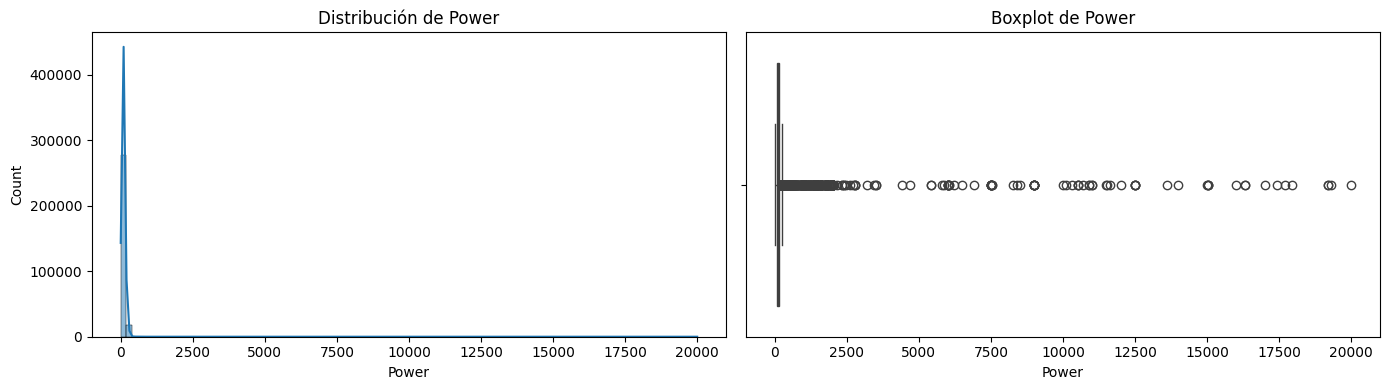

In [89]:
plt.figure(figsize=(14, 4))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df['Power'], bins=100, kde=True)
plt.title('Distribución de Power')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Power'])
plt.title('Boxplot de Power')

plt.tight_layout()
plt.show()

In [90]:
# Eliminamos todos los valores usando el metodo de rango intercuartilico, a su vez, 
# eliminamos los valores donde Power nos da 0, debido a que no existe un vehioculo con 0 caballos de fuerza, colocamos que el umbral minimo es de 50)
df, umbrales_power = limpiar_outliers(df, 'Power', 50)

Valores eliminados por debajo de 50: 29861
Valores eliminados por encima de 255 (outliers superiores): 5050
Total restante: 260734 filas


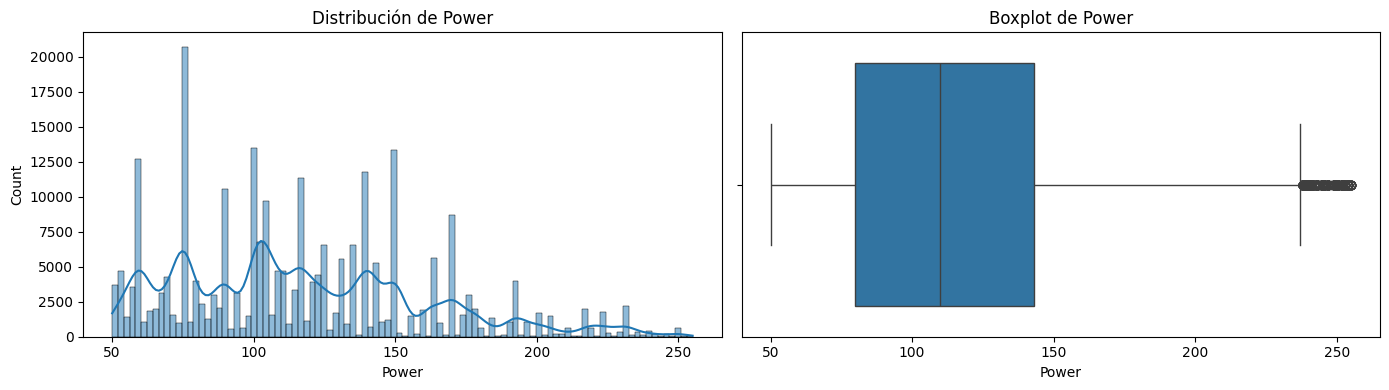

In [91]:
plt.figure(figsize=(14, 4))

# Histograma
plt.subplot(1, 2, 1)
sns.histplot(df['Power'], bins=100, kde=True)
plt.title('Distribución de Power')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Power'])
plt.title('Boxplot de Power')

plt.tight_layout()
plt.show()

In [92]:
# Hacemos drop a los valores nulos
df = df.dropna()

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a><br> <b>Éxito</b> - Excelente visualización y depuración. Usaste gráficos efectivos para identificar outliers y aplicaste un método robusto (IQR) para limpiarlos. Justificaste con claridad la eliminación de valores irreales, lo cual fortalece la calidad del dataset para el modelado. ¡Tu análisis se ve cada vez más profesional! </div>


## Entrenamiento del modelo 

Separaremos mi dataset en dos variaciones, una con OHE y uno sin OHE, ambas tendran un standard scaler.

In [93]:
# Aplicamos un train_test
X = df.drop(columns='Price')
y = df['Price']

# Aplicaremos OHE 
X_ohe = (pd.get_dummies(X, drop_first=True))

# Train test Split con 75% train y 25% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train test Split para OHE
X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = train_test_split(X_ohe, y, test_size=0.25, random_state=42)

In [94]:
numeric = X_train.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
scaler.fit(X_train[numeric])
X_train[numeric]=scaler.transform(X_train[numeric])
X_test[numeric]=scaler.transform(X_test[numeric])

scaler = StandardScaler()
scaler.fit(X_train_ohe[numeric])
X_train_ohe[numeric]=scaler.transform(X_train[numeric])
X_test_ohe[numeric]=scaler.transform(X_test[numeric])

In [95]:
# Función personalizada para calcular RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

### Random Forest

In [ ]:
# Random Forest GridSearchCV
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Pipeline con StandardScaler y RandomForest
pipeline = Pipeline([
    ('model', RandomForestRegressor(random_state=42))
])

# Grid de hiperparámetros
param_grid = {
    'model__n_estimators': [50, 100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_split': [2, 5],
    'model__min_samples_leaf': [1, 2]
}

# GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=4, scoring=rmse_scorer, n_jobs=-1, verbose=1)

#Correr tiempo
start_time = time.time()

# Entrenar
grid_search.fit(X_train_ohe, y_train)
forest_time = time.time() - start_time

# Resultados
print(f"Mejor RMSE (negativo): {grid_search.best_score_:.2f}")
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Tiempo de Ejecución:", forest_time)

Fitting 4 folds for each of 36 candidates, totalling 144 fits


/Volumes/Carlos Vallejo SSD/Triple Ten/tripleten-ds/ttds_venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Mejor RMSE (negativo): -1279.61
Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 2, 'model__min_samples_split': 5, 'model__n_estimators': 200}
Tiempo de Ejecución: 2908.1670479774475


Ya encontrados estos parametros, vemos cuanto tiempo tarda en entrenarse este modelo con los hiperparametros optimizados.

In [ ]:
%%time

# Entrenar el modelo con los mejores hiperparámetros encontrados
best_rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42
)

# Entrenamiento
best_rf.fit(X_train_ohe, y_train_ohe)

# Predicción sobre el conjunto de prueba
y_pred_test = best_rf.predict(X_test_ohe)

# Cálculo del RMSE
rmse_test = rmse(y_test, y_pred_test)

# Mostrar resultados
print(f"✅ RMSE en conjunto de prueba (Random Forest): {rmse_test:.2f}")

✅ RMSE en conjunto de prueba: 1295.47
CPU times: user 4min 13s, sys: 1.83 s, total: 4min 15s
Wall time: 4min 17s


### Decision Tree Regressor

In [ ]:
%%time
# Scorer
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Pipeline con StandardScaler y DecisionTree
pipeline = Pipeline([
    ('model', DecisionTreeRegressor(random_state=42))
])

# Grid de hiperparámetros para Decision Tree
param_grid = {
    'model__max_depth': [None, 5, 10, 15, 20],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

# Configurar GridSearchCV
grid_search = GridSearchCV(pipeline, 
                           param_grid, 
                           cv=4, 
                           scoring=rmse_scorer, 
                           n_jobs=-1, 
                           verbose=1)

# Ejecutar entrenamiento
grid_search.fit(X_train_ohe, y_train_ohe)


# Resultados
print(f"✅ Mejor RMSE (negativo): {grid_search.best_score_:.2f}")
print(f"🔧 Mejores parámetros: {grid_search.best_params_}")

Fitting 4 folds for each of 45 candidates, totalling 180 fits
✅ Mejor RMSE (negativo): -1441.30
🔧 Mejores parámetros: {'model__max_depth': None, 'model__min_samples_leaf': 4, 'model__min_samples_split': 10}
CPU times: user 2.62 s, sys: 533 ms, total: 3.15 s
Wall time: 47.2 s


In [ ]:
%%time
# Mejores Parametros
best_tree = DecisionTreeRegressor(
    max_depth=None,
    min_samples_split=10,
    min_samples_leaf=4,
    random_state=42
)

# Medir tiempo de entrenamiento
start_time = time.time()
best_tree.fit(X_train_ohe, y_train)
tree_train_time = time.time() - start_time

# Predicción en test
y_pred_tree = best_tree.predict(X_test_ohe)

# Calcular RMSE
rmse_test_tree = rmse(y_test, y_pred_tree)

# Resultados
print(f"✅ RMSE en conjunto de prueba (Decision Tree): {rmse_test_tree:.2f}")

✅ RMSE en conjunto de prueba (Decision Tree): 1404.94
⏱️ Tiempo de entrenamiento final: 1.99 segundos
CPU times: user 1.94 s, sys: 71.9 ms, total: 2.02 s
Wall time: 2.03 s


### Regresión Lineal

In [ ]:
%%time 
# Regresion Lineal
rmse_scorer = make_scorer(rmse, greater_is_better=False)

categorical = X.select_dtypes(include='object').columns
numerical = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# RMSE
rmse_test_lr = rmse(y_test, y_pred)

# Resultados
print(f"✅ RMSE en conjunto de prueba (Linear Regression): {rmse_test_lr:.2f}")

✅ RMSE en conjunto de prueba (Linear Regression): 2057.44
CPU times: user 923 ms, sys: 19.2 ms, total: 942 ms
Wall time: 946 ms


In [ ]:
%%time
# Ridge
rmse_scorer = make_scorer(rmse, greater_is_better=False)

categorical = X.select_dtypes(include='object').columns
numerical = X.select_dtypes(include=['int64', 'float64']).columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical)
])

pipeline_ridge = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Ridge(alpha=1.0))  # Puedes ajustar alpha si deseas
])

pipeline_ridge.fit(X_train, y_train)
y_pred_ridge = pipeline_ridge.predict(X_test)

rmse_test_ridge = rmse(y_test, y_pred_ridge)
print(f"✅ RMSE en conjunto de prueba (Ridge): {rmse_test_ridge:.2f}")

✅ RMSE en conjunto de prueba (Ridge): 2057.30
CPU times: user 513 ms, sys: 15.3 ms, total: 529 ms
Wall time: 530 ms


In [ ]:
%%time
# Lasso
pipeline_lasso = Pipeline([
    ('preprocessing', preprocessor),
    ('model', Lasso(alpha=1.0, max_iter=10000))  # max_iter aumentado por si hay muchas features
])

pipeline_lasso.fit(X_train, y_train)
y_pred_lasso = pipeline_lasso.predict(X_test)

rmse_test_lasso = rmse(y_test, y_pred_lasso)
print(f"✅ RMSE en conjunto de prueba (Lasso): {rmse_test_lasso:.2f}")

✅ RMSE en conjunto de prueba (Lasso): 2095.27
CPU times: user 37.9 s, sys: 3.92 s, total: 41.8 s
Wall time: 22.6 s


### Catboost | Potenciacion de Gradiente

In [ ]:
# Lista de mis features categoricas
categorical_features = X.select_dtypes(include='object').columns.tolist()
categorical_features

['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

In [ ]:
%%time

rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Envolvemos CatBoost en el wrapper de sklearn
catboost_model = CatBoostRegressor(
    verbose=0,
    random_state=42,
    loss_function='RMSE'
)

# Definimos los hiperparámetros
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.03, 0.1],
    'depth': [4, 6],
    'l2_leaf_reg': [1, 3]
}

# Usamos GridSearchCV
grid_search = GridSearchCV(
    estimator=catboost_model,
    param_grid=param_grid,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

# Entrenamos el modelo
grid_search.fit(X_train, y_train, cat_features=categorical_features)

# Resultados
print(f"✅ Mejor RMSE (negativo): {grid_search.best_score_:.2f}")
print(f"🔧 Mejores parámetros: {grid_search.best_params_}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits
✅ Mejor RMSE (negativo): -1344.74
🔧 Mejores parámetros: {'depth': 6, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
CPU times: user 1min 17s, sys: 5.79 s, total: 1min 23s
Wall time: 4min 3s


In [ ]:
%%time
# Mejores Parametros

best_cat = CatBoostRegressor(
    depth=6,
    iterations=500,
    l2_leaf_reg=1,
    learning_rate=0.1,
    random_state=42
)

# Medir tiempo de entrenamiento
best_cat.fit(X_train, y_train, cat_features=categorical_features, verbose=0)

# Predicción en test
y_pred_cat = best_cat.predict(X_test)

# Calcular RMSE
rmse_test_cat = rmse(y_test, y_pred_cat)

# Resultados
print(f"✅ RMSE en conjunto de prueba (CatBoost): {rmse_test_cat:.2f}")

✅ RMSE en conjunto de prueba (CatBoost): 1335.75
CPU times: user 1min 15s, sys: 5.01 s, total: 1min 20s
Wall time: 13.3 s


### LightGBM

In [96]:
# Convierte todas las columnas categóricas a tipo 'category'
for col in categorical_features:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

In [100]:
%%time

# Crear el modelo
lgb_model = lgb.LGBMRegressor(verbosity=-1, random_state=42)

# Entrenar con GridSearchCV
grid = {
    'num_leaves': [31, 50],
    'max_depth': [-1, 10],
    'learning_rate': [0.05, 0.1],
    'n_estimators': [100, 200]
}

grid_search = GridSearchCV(
    estimator=lgb_model,
    param_grid=grid,
    scoring=rmse_scorer,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Entrenar
grid_search.fit(X_train, y_train, categorical_feature='auto')

# Predecir y evaluar
y_pred = grid_search.predict(X_test)
rmse_lgb = rmse(y_test, y_pred)
print(f"✅ RMSE en test con LightGBM: {rmse_lgb:.2f}")
print(f"🔧 Mejores parámetros: {grid_search.best_params_}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Volumes/Carlos Vallejo SSD/Triple Ten/tripleten-ds/ttds_venv/lib/python3.10/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


✅ RMSE en test con LightGBM: 1234.59
🔧 Mejores parámetros: {'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 200, 'num_leaves': 50}
CPU times: user 3.13 s, sys: 2.49 s, total: 5.62 s
Wall time: 47.2 s


In [102]:
%%time 
# Configurar y entrenar el modelo final con los mejores hiperparámetros
best_lgbm = lgb.LGBMRegressor(
    learning_rate=0.1,
    max_depth=-1,
    n_estimators=200,
    num_leaves=50,
    random_state=42,
    verbosity=-1
)

# Entrenar modelo
best_lgbm.fit(X_train, y_train, categorical_feature=categorical_features)

# Predecir en conjunto de prueba
y_pred_lgbm = best_lgbm.predict(X_test)

# Calcular RMSE
rmse_lgbm = rmse(y_test, y_pred_lgbm)

# Mostrar resultados
print(f"✅ RMSE en test con LightGBM: {rmse_lgbm:.2f}")

✅ RMSE en test con LightGBM: 1234.59
CPU times: user 2.94 s, sys: 2.21 s, total: 5.15 s
Wall time: 2.31 s


### XGBoost

In [105]:
%%time 
# Scorer con RMSE negativo para GridSearchCV
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Pipeline (XGBoost no requiere escalado para Random Forest style models)
pipeline = Pipeline([
    ('model', XGBRegressor(random_state=42, n_jobs=-1, verbosity=0))
])

# Grid de hiperparámetros a ajustar
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [6, 10],
    'model__learning_rate': [0.1, 0.3],
    'model__subsample': [0.8, 1],
}

# GridSearch
grid_search_xgb = GridSearchCV(
    pipeline,
    param_grid,
    cv=3,
    scoring=rmse_scorer,
    n_jobs=-1,
    verbose=1
)

# Entrenar el modelo
grid_search_xgb.fit(X_train_ohe, y_train_ohe)

# Predicción
y_pred_xgb = grid_search_xgb.predict(X_test_ohe)

# Calcular RMSE final
rmse_xgb = rmse(y_test_ohe, y_pred_xgb)

# Mostrar resultados
print(f"\n✅ RMSE en test con XGBoost: {rmse_xgb:.2f}")
print(f"🔧 Mejores parámetros: {grid_search_xgb.best_params_}")

Fitting 3 folds for each of 16 candidates, totalling 48 fits


/Volumes/Carlos Vallejo SSD/Triple Ten/tripleten-ds/ttds_venv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Volumes/Carlos Vallejo SSD/Triple Ten/tripleten-ds/ttds_venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
17 fits failed out of a total of 48.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
17 fits failed with the following error:
Traceback (most recent call last):
  File "/Volumes/Carlos Vallejo SSD/Triple Ten/tripleten-ds/ttds_venv/lib/python3.10/site-packages/sklearn/model_selection/_validatio


✅ RMSE en test con XGBoost: 1224.78
🔧 Mejores parámetros: {'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 200, 'model__subsample': 0.8}
CPU times: user 14.6 s, sys: 1.19 s, total: 15.8 s
Wall time: 55.2 s


In [106]:
%%time

best_xgb = XGBRegressor(
    learning_rate=0.1,
    max_depth=10,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
    n_jobs=-1
)
best_xgb.fit(X_train_ohe, y_train)
y_pred_test = best_xgb.predict(X_test_ohe)

rmse_test = rmse(y_test, y_pred_test)
print(f"✅ RMSE final con mejores hiperparámetros (XGBoost): {rmse_test:.2f}")

✅ RMSE final con mejores hiperparámetros (XGBoost): 1224.78
CPU times: user 14 s, sys: 827 ms, total: 14.9 s
Wall time: 3.76 s


<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a><br> <b>Éxito</b> - Excelente bloque de modelado. Probaste múltiples enfoques, ajustaste hiperparámetros con GridSearchCV y comparaste rendimiento de forma clara usando RMSE, tiempos de ejecución y preprocesamiento adecuado. Tu implementación es sólida, variada y bien argumentada. ¡Tu dominio del pipeline de machine learning está quedando muy bien demostrado! </div>



## Análisis

In [111]:
df_modelos = pd.DataFrame({
    'Modelo': [
        'Random Forest', 'Decision Tree', 'Regresión Lineal',
        'Regresión Lasso', 'Regresión Ridge', 'CatBoost',
        'LightGBM', 'XGBoost'
    ],
    'RMSE': [
        1295.47, 1404.94, 2057.44,
        2095.27, 2057.30, 1335.75,
        1234.59, 1224.78
    ],
    'Time(s)': [
        257.0, 2.03, 0.946,
        22.6, 0.53, 13.3,
        2.31, 3.76
    ]
})

# Ver el resultado
df_modelos.sort_values(by='RMSE')

,Modelo,RMSE,Time(s)
7,XGBoost,1224.78,3.760
6,LightGBM,1234.59,2.310
0,Random Forest,1295.47,257.000
5,CatBoost,1335.75,13.300
1,Decision Tree,1404.94,2.030
4,Regresión Ridge,2057.30,0.530
2,Regresión Lineal,2057.44,0.946
3,Regresión Lasso,2095.27,22.600


### Comparación de Modelos de Regresión — Predicción de Precio

| Modelo                  | RMSE (Test) | Tiempo de Entrenamiento |
|-------------------------|-------------|--------------------------|
| **XGBoost**             | **1224.78** | **3.76 s**               |
| LightGBM                | 1234.59     | 2.31 s                   |
| Random Forest           | 1295.47     | 4 min 17 s               |
| CatBoost                | 1335.75     | 13.3 s                   |
| Decision Tree           | 1404.94     | 2.03 s                   |
| Ridge Regression        | 2057.30     | 530 ms                   |
| Linear Regression       | 2057.44     | 946 ms                   |
| Lasso Regression        | 2095.27     | 22.6 s                   |

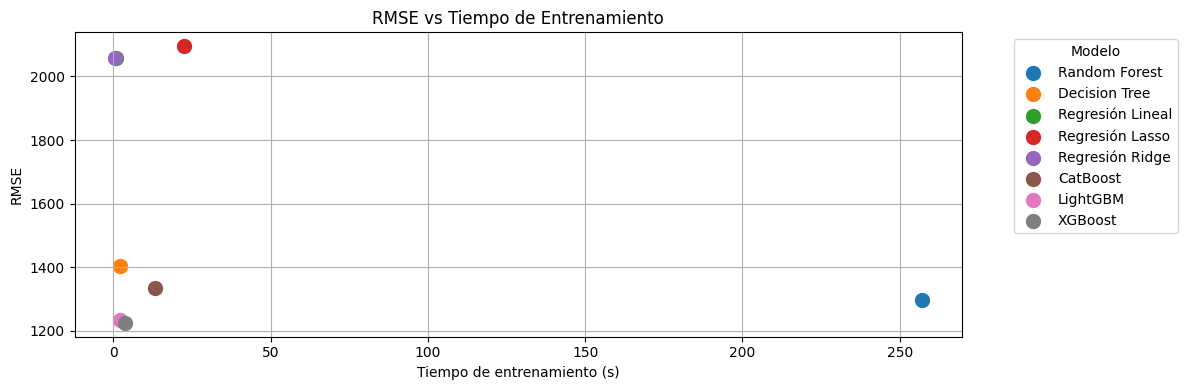

In [118]:
plt.figure(figsize=(12,4))

# Usar palette de seaborn para varios colores
palette = sns.color_palette("tab10", n_colors=len(df_modelos))

# Graficar puntos con diferentes colores y etiquetas para legend
for i, modelo in enumerate(df_modelos['Modelo']):
    plt.scatter(df_modelos['Time(s)'][i], df_modelos['RMSE'][i], 
                color=palette[i], label=modelo, s=100)

plt.xlabel('Tiempo de entrenamiento (s)')
plt.ylabel('RMSE')
plt.title('RMSE vs Tiempo de Entrenamiento')
plt.grid(True)
plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Conclusiones

En general los modelos basados en boosting entrergaron los valores mas bajos de RMSE en el conjunto de prueba. Lo que indica que predicen el valor de mercado con mas precision que un modelo de regresion o arbol de decision basico.   

LightGBM y XGBoost fueron de los modelos mas rapidos de entrenar, CatBoost estuvo cerca. Random Forest aun que tuvo un RMSE igualmente bajo, tomo muchisimo mas tiempo de entrenamiento.

Tanto el modelo LightGBM como XGBoost son adecuados para aplicaciones en tiempo real, debido a su gran tiempo de respuesta. En este caso utilizariamos LightGBM, debido a que aunque XGBoost es un poco mas accurate y casi tiene mismo tiempo de entrenamiento que LightGBM, LightGBM tiene la ventaja de no necesitar utilizar OHE, lo que simplifica el pipeline debido a que podemos manejar variables categoricas, reduciendo la dimensionalidad y ayudando a que podamos escalarlo de mejor manera.

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos

<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a><br> <b>Éxito</b> - Muy buen cierre del proyecto. Presentaste una comparación clara entre modelos usando métricas clave y visualizaciones efectivas. Tus conclusiones son lógicas, bien argumentadas y alineadas con los requerimientos de negocio. Elegiste adecuadamente el modelo final justificando precisión, eficiencia y escalabilidad. Tu análisis es maduro y convincente. </div>


## Comentario final del revisor 



<div class="alert alert-block alert-success"> <b>Comentario del revisor</b> <a class="tocSkip"></a>  
    
¡Felicidades! Tu proyecto está <strong>aprobado</strong>. Has demostrado un excelente manejo del flujo completo de machine learning: desde la exploración y limpieza de datos, hasta el entrenamiento, ajuste de hiperparámetros y análisis comparativo de modelos. El trabajo es meticuloso, bien estructurado y con decisiones justificadas en cada etapa.

#### Puntos Positivos:

* **Procesamiento de datos:** Muy buen criterio en la depuración de outliers y codificación de variables, con decisiones bien sustentadas.
* **Visualización y análisis gráfico:** Uso claro y pertinente de histogramas, boxplots y heatmaps para guiar el preprocesamiento.
* **Ingeniería de características:** Correcta transformación y escalado de variables numéricas y categóricas, aplicando variantes con OHE y sin él según el modelo.
* **Comparación de modelos:** Excelente evaluación comparativa basada en RMSE y tiempos de entrenamiento. La justificación final de LightGBM como modelo ideal es sólida y realista para una implementación en producción.

¡Tu dominio técnico y tu claridad analítica destacan con fuerza en este proyecto! </div>
